# Meanshift (Clustering)
Meanshift is a clustering algorithm that does not require to provide the number of clusters (`k`) in advance.

This is inspired by the [fast.ai coure](https://course.fast.ai/Lessons/lesson12.html)

## Setup

In [231]:
import math
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

## Fake data

In [217]:
torch.manual_seed(0xc0ffee)

n_clusters = 6
n_samples = 250

data = []
centroids = torch.rand(n_clusters, 2) * 100 - 50
for centroid in centroids:
    data.append(MultivariateNormal(centroid, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,)))
data = torch.cat(data)

In [218]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

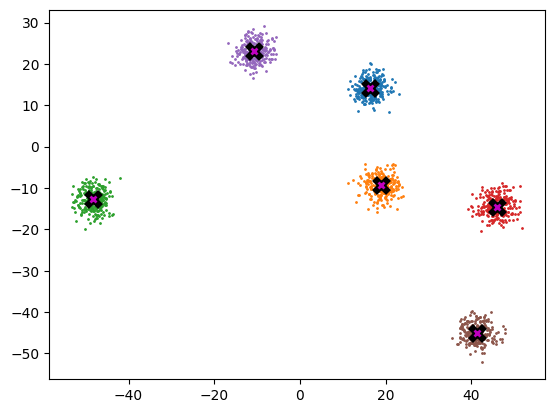

In [219]:
plot_data(centroids, data, n_samples)

## Code
It tastes a bit like simulating gravity. For each point we compute a new position as the weighted average of the distances to every other point. With further points having less influence on the average.

The distance decay uses a Gaussian kernel $e^{-\frac{||x - x'||^2}{2\sigma^2}} \over {x'\sqrt{2\sigma^2\pi}}$

In [220]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [221]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

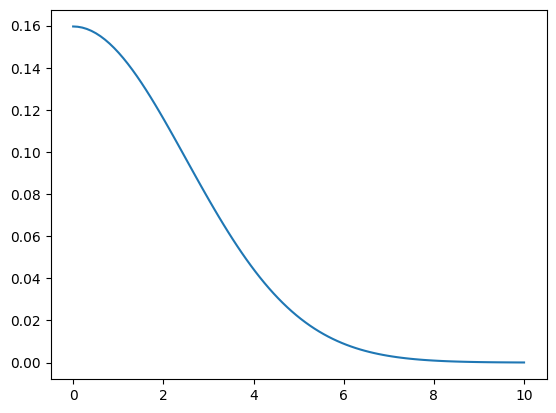

In [222]:
plot_func(lambda x: gaussian(x, 2.5))

In [223]:
X = data.clone()

In [224]:
def one_update(X):
    for i, x in enumerate(X):
        # dist = ((X - x)**2).sum(1).sqrt()                         # naive
        # dist = torch.einsum('ij, ij -> i', X - x, X - x).sqrt()   # using einsum
        dist = torch.norm(X - x, dim=1)                             # simplest
        weights = gaussian(dist, 2.5)
        X[i] = (X * weights.unsqueeze(1)).sum(dim=0) / weights.sum()

In [228]:
def meanshift(data, n_iter=5):
    X = data.clone()
    for it in range(n_iter):
        one_update(X)
    return X

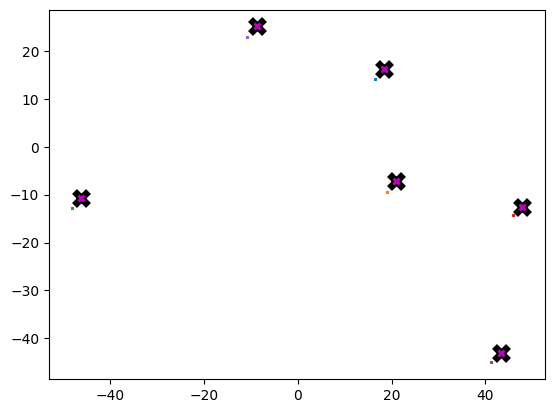

In [232]:
X = meanshift(X)
plot_data(centroids + 2, X, n_samples)

## Animation

In [230]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)
     
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())